In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../../'))
sys.path.insert(0, project_root)

from core.ga.ga_member import Member
from core.ga.ga_params import GeneticAlgorithmParams

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances
from core.model.model_sensitivities import ModelSensitivities

from core.plotting.plotting import plot_crop_growth_results

## Analysis across runs

In [2]:
ga_parallel_results_folder = "ga_parallel_results"
values_costs_folder        = "unique_values_costs_results"
input_disturbances_csv     = "io/inputs/hourly_prcp_rad_temp_iowa.csv"

## Revenue analysis

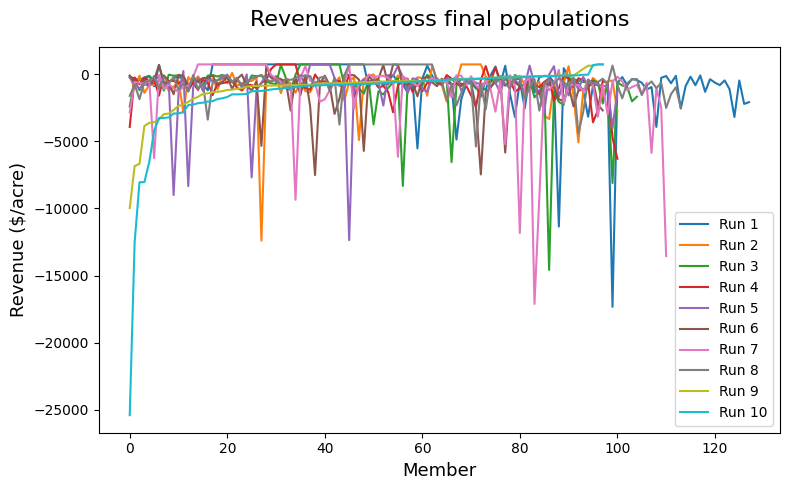

In [3]:
fig, ax = plt.subplots(figsize=(8, 5))

for i in range(1, 11): # Runs 1 to 10

    values_costs_path = os.path.join(
        ga_parallel_results_folder,
        values_costs_folder,
        f"ga_parallel_result_unique_values_and_costs_{i}.csv"
    )

    with open(values_costs_path, "rb") as f:
        unique_values_costs = np.loadtxt(f, delimiter=",", skiprows=1)
        unique_costs = unique_values_costs[:, -2]  # The second to last column is the cost
        unique_revenues = unique_values_costs[:, -1]  # The last column is the revenue

    member_ids = np.arange(unique_revenues.shape[0])
    ax.plot(member_ids, unique_revenues[::-1], label=f"Run {i}")

ax.set_title("Revenues across final populations", fontsize=16, pad=15)
ax.set_xlabel("Member", fontsize=13)
ax.set_ylabel("Revenue ($/acre)", fontsize=13)
ax.legend()

fig.tight_layout()

## Growth analysis - Best in the final populations

In [4]:
# Set up Member attributes common to all runs
ga_params = GeneticAlgorithmParams()
carrying_capacities = ModelCarryingCapacities()
input_disturbances = ModelDisturbances.from_defaults(path=os.path.join(project_root, input_disturbances_csv))
growth_rates = ModelGrowthRates()
model_params = ModelParams(verbose=True)
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours, # m/hr
    A0=carrying_capacities.kA/model_params.simulation_hours, # m2/hr
    N0=carrying_capacities.kN/model_params.simulation_hours, # number/hr
    c0=carrying_capacities.kc/model_params.simulation_hours, # number/hr
    P0=carrying_capacities.kP/model_params.simulation_hours  # kg/hr
)
default_typical_disturbances = ModelTypicalDisturbances()
typical_disturbances = ModelTypicalDisturbances(
    typical_water       = default_typical_disturbances.typical_water * model_params.dt,
    typical_fertilizer  = default_typical_disturbances.typical_fertilizer * model_params.dt,
    typical_temperature = default_typical_disturbances.typical_temperature * model_params.dt,
    typical_radiation   = default_typical_disturbances.typical_radiation * model_params.dt
)
sensitivities = ModelSensitivities()

Analyzing best member from run 1...
Revenue: $732.0151878931108 with inputs: IF=2180.6889931261135, IA=0.16052169009727058, FF=1460.976514193387, FA=125.38554553302795
Analyzing best member from run 2...
Revenue: $729.2564142931095 with inputs: IF=869.2358015278548, IA=0.15249264793010606, FF=1506.8630881522909, FA=133.30415023573775
Analyzing best member from run 3...
Revenue: $728.9031347347095 with inputs: IF=1708.898191216558, IA=0.17609418260033266, FF=1535.5625253727865, FA=132.5171830142105
Analyzing best member from run 4...
Revenue: $725.7708926077455 with inputs: IF=2134.626141559078, IA=0.28475595787867003, FF=1558.9915683809145, FA=133.9352350105952
Analyzing best member from run 5...
Revenue: $722.7722612833414 with inputs: IF=1847.9084450184405, IA=0.33372377287968985, FF=1595.5351322909007, FA=137.0084937377979
Analyzing best member from run 6...
Revenue: $717.0281415520406 with inputs: IF=1340.0953446208077, IA=0.0489532074104652, FF=1563.9758149560798, FA=153.631162282

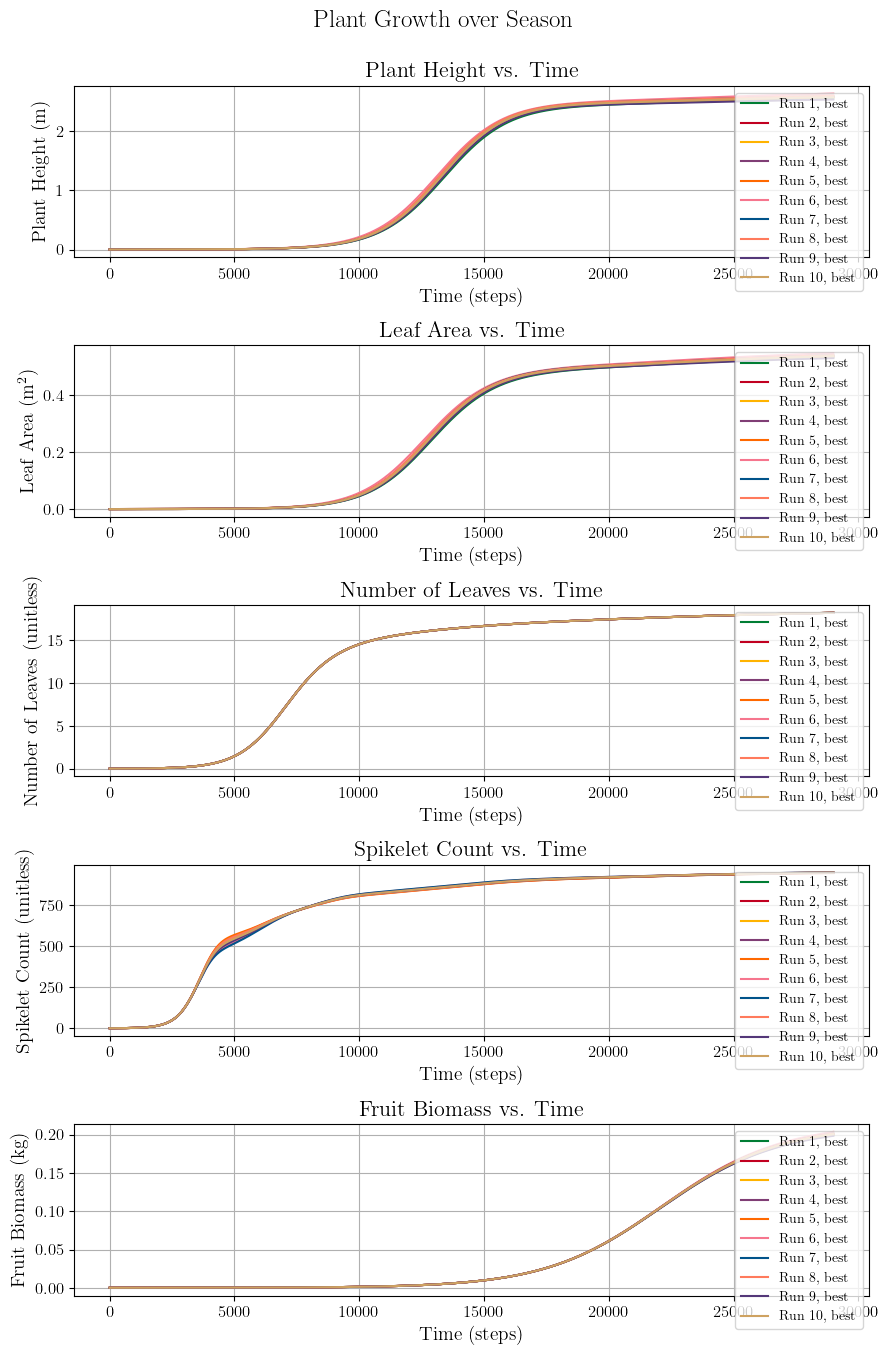

In [5]:
# Initialize storage of state variables for all runs
hs = []
As = []
Ns = []
cs = []
Ps = []
labels = []

# Loop over all 10 of the best runs to analyze plant growth
for i in range(1, 11): # Runs 1 to 10

    print(f"Analyzing best member from run {i}...")

    # Load the best member's input values from the corresponding CSV file
    values_costs_path = os.path.join(
        ga_parallel_results_folder,
        values_costs_folder,
        f"ga_parallel_result_unique_values_and_costs_{i}.csv"
    )
    with open(values_costs_path, "rb") as f:
        unique_values_costs = np.loadtxt(f, delimiter=",", skiprows=1)

    best_index = np.argmax(unique_values_costs[:, -1])  # The last column is the revenue
    revenue = unique_values_costs[best_index, -1]
    irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount = unique_values_costs[best_index, 0:4]
    print(f'Revenue: ${revenue} with inputs: IF={irrigation_frequency}, IA={irrigation_amount}, FF={fertilizer_frequency}, FA={fertilizer_amount}')
    
    member = Member(
        ga_params            = ga_params,
        carrying_capacities  = carrying_capacities,
        disturbances         = input_disturbances,
        growth_rates         = growth_rates,
        initial_conditions   = initial_conditions,
        model_params         = model_params,
        typical_disturbances = typical_disturbances,
        sensitivities        = sensitivities,
        values = np.array([irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount])
    )
    member.get_cost()

    # Read output CSV
    output = pd.read_csv('output_get_cost.csv')

    hs.append(output['h'].to_numpy())
    As.append(output['A'].to_numpy())
    Ns.append(output['N'].to_numpy())
    cs.append(output['c'].to_numpy())
    Ps.append(output['P'].to_numpy())
    labels.append(f'Run {i}, best')

plot_crop_growth_results(
    hs=hs,
    As=As,
    Ns=Ns,
    cs=cs,
    Ps=Ps,
    labels=labels
)

## Growth analysis - Worst in the final populations

Analyzing worst member from run 1...
Revenue: $-17326.22089140163 with inputs: IF=871.0361828495144, IA=0.39185684831483103, FF=30.005831513513286, FA=300.143565677101
Analyzing worst member from run 2...
Revenue: $-12394.108458018523 with inputs: IF=2133.166855326793, IA=9.690633984819888, FF=75.51836036179935, FA=515.967005849983
Analyzing worst member from run 3...
Revenue: $-14580.970710855967 with inputs: IF=511.9702063892202, IA=0.02207964223415182, FF=54.50815342798408, FA=448.05807126647426
Analyzing worst member from run 4...
Revenue: $-6296.403011115572 with inputs: IF=23.840034577700127, IA=0.8827501410294081, FF=120.01435075120797, FA=412.7834878522601
Analyzing worst member from run 5...
Revenue: $-12360.36418840854 with inputs: IF=1743.2241236393218, IA=5.262297845429159, FF=81.99163165534732, FA=558.2390063803506
Analyzing worst member from run 6...
Revenue: $-7511.234263419472 with inputs: IF=1632.020963203011, IA=3.449270853205725, FF=57.485629400672664, FA=244.2161947

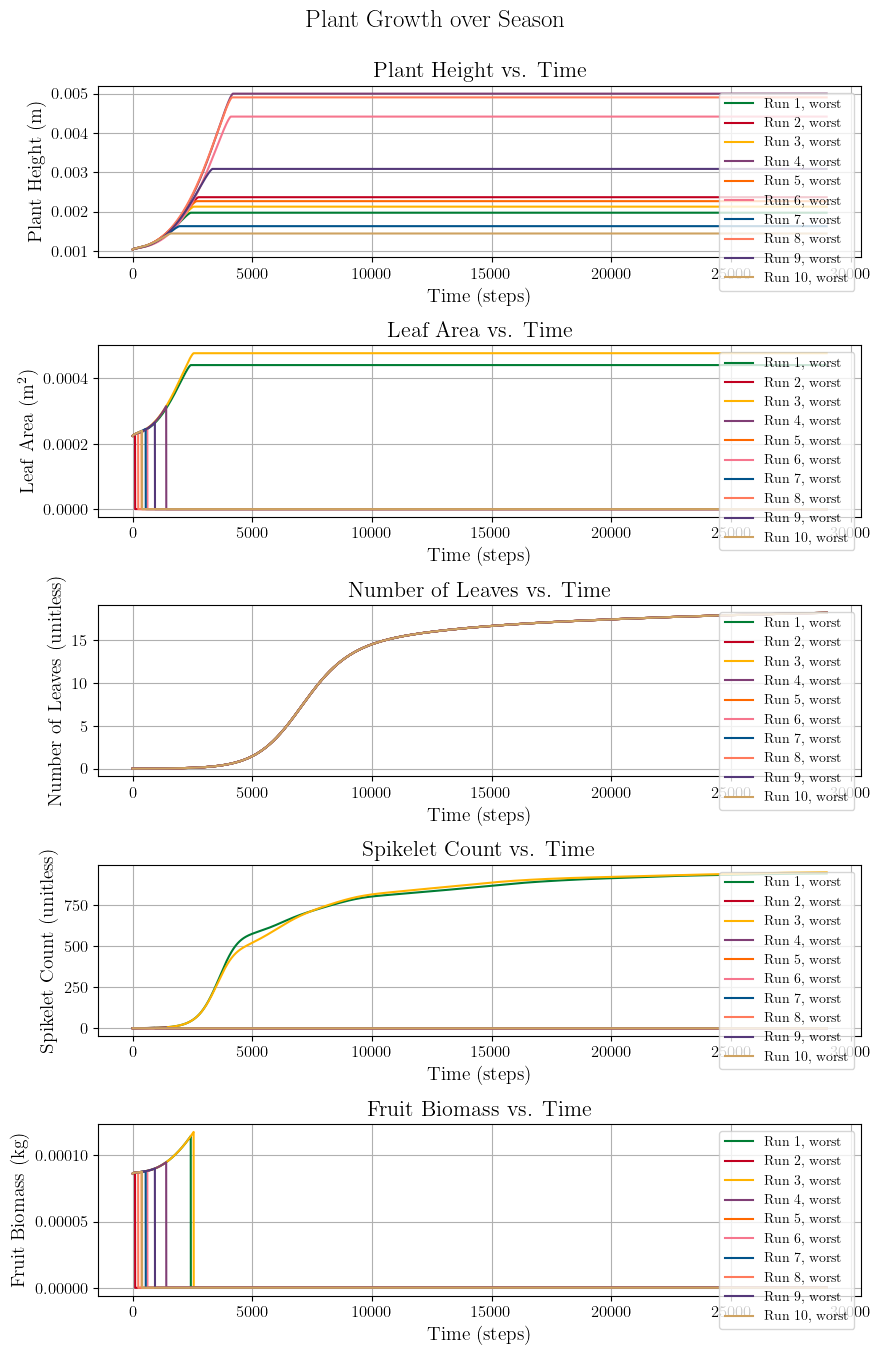

In [6]:
# Initialize storage of state variables for all runs
hs = []
As = []
Ns = []
cs = []
Ps = []
labels = []

# Loop over all 10 of the best runs to analyze plant growth
for i in range(1, 11): # Runs 1 to 10

    print(f"Analyzing worst member from run {i}...")

    # Load the worst member's input values from the corresponding CSV file
    values_costs_path = os.path.join(
        ga_parallel_results_folder,
        values_costs_folder,
        f"ga_parallel_result_unique_values_and_costs_{i}.csv"
    )
    with open(values_costs_path, "rb") as f:
        unique_values_costs = np.loadtxt(f, delimiter=",", skiprows=1)

    worst_index = np.argmin(unique_values_costs[:, -1])  # The last column is the revenue
    revenue = unique_values_costs[worst_index, -1]
    irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount = unique_values_costs[worst_index, 0:4]
    print(f'Revenue: ${revenue} with inputs: IF={irrigation_frequency}, IA={irrigation_amount}, FF={fertilizer_frequency}, FA={fertilizer_amount}')
    
    member = Member(
        ga_params            = ga_params,
        carrying_capacities  = carrying_capacities,
        disturbances         = input_disturbances,
        growth_rates         = growth_rates,
        initial_conditions   = initial_conditions,
        model_params         = model_params,
        typical_disturbances = typical_disturbances,
        sensitivities        = sensitivities,
        values = np.array([irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount])
    )
    member.get_cost()

    # Read output CSV
    output = pd.read_csv('output_get_cost.csv')

    hs.append(output['h'].to_numpy())
    As.append(output['A'].to_numpy())
    Ns.append(output['N'].to_numpy())
    cs.append(output['c'].to_numpy())
    Ps.append(output['P'].to_numpy())
    labels.append(f'Run {i}, worst')

plot_crop_growth_results(
    hs=hs,
    As=As,
    Ns=Ns,
    cs=cs,
    Ps=Ps,
    labels=labels
)